In [ ]:
!pip install top2vec[sentence_encoders]

In [ ]:
!pip install pysentimiento

In [69]:
!pip install pyldavis

     |████████████████████████████████| 1.7 MB 19.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=ea232204966be0c9aaa5e4861cc78b15025c64652662071179b1482467780bd4
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyldavis


In [62]:
import top2vec
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.corpora as corpora
import pprint
import spacy
# import pyLDAvis 
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 're', 'youre', 'use', 'shouldnt', 'this', 'just', 'like', 'the', 'httpurl', 'emoji'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:

def remove_word(text, word):
    return re.sub(word, ' ', text, flags=re.I)

def clean_text(text, remove_hashtag = False, suppress_punctuation = False, remove_stopwords=False):
    """
    returns cleaned text
    """
    # remove mentions
    
    
    text = re.sub('@[a-zA-Z0-9_]+', '', text, flags=re.I)
    # REMOVE LINKS
    text =re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', text,
                 flags=re.I)
    # remove spl characters and numbers and supress #
    
    if suppress_punctuation:
        text = re.sub('[^A-Za-z\ #]+', '', text, flags=re.I|re.M)
    else:
        text = re.sub('[^A-Za-z\ ?!.#]+', '', text, flags=re.I|re.M)
    if remove_hashtag:
        text = re.sub('#', ' ', text)
    text = remove_word(text, "amp")
    text = remove_word(text, "de ")
    text = remove_word(text, "httpurl")
    text = remove_word(text, "emoji")

    text = text.strip().lower()
    if remove_stopwords:
        temp = [w for w in nltk.word_tokenize(text) if w not in stop_words]
        text = ' '.join(temp)    
    return text


    

In [49]:
stop_words.extend(['from', 're', 'youre', 'use', 'shouldnt', 'this', 'just', 'like', 'the', 'elon', 'musk'])

In [15]:
fname = "st_elon_twitter_100_"

In [24]:
dfs = []
for i in range(1, 16):
  dfs.append(pd.read_csv(fname+str(i)+".csv")[["date", "content"]])
len(dfs)

15

In [26]:
stk = pd.concat(dfs, ignore_index=True)
stk.shape

(1500, 2)

In [29]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

Downloading:   0%|          | 0.00/334 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/838k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/925 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/415M [00:00<?, ?B/s]

In [35]:
from pysentimiento.preprocessing import preprocess_tweet

stk['cleaned'] = stk.content.map(lambda x: preprocess_tweet(x, lang="en", shorten=2))

0       Elon bought Twitter shares for $2bn+ when he c...
1       Elon Musk se convierte en accionista mayoritar...
2       Elon Musk se convierte en accionista mayoritar...
3                @USER Elon already making twitter better
4       if elon musk owns 9% of twitter now, does that...
                              ...                        
1495    @USER @USER @USER @USER Now DeSantis is going ...
1496    Elon Musk willing to invest $15 billion to tak...
1497    @USER If I had a nickel for every time I saw t...
1498    @USER This can't be real, right? George Wallac...
1499    Elon Musk Reverses Decision to Join twitters B...
Name: cleaned, Length: 1500, dtype: object

In [37]:
sentiment_stock = []
# i = 0
for rep in stk.cleaned.to_list():
  sentiment_stock.append(analyzer.predict(rep).output)

In [38]:
stk.to_csv('elon_stk_combined.csv')

In [79]:
pd.DataFrame(sentiment_stock).value_counts(normalize=True)

NEU    0.630000
NEG    0.335333
POS    0.034667
dtype: float64

In [ ]:
from top2vec import Top2Vec

model = Top2Vec(stk_sent, embedding_model='universal-sentence-encoder')

In [127]:
model.get_num_topics()

6

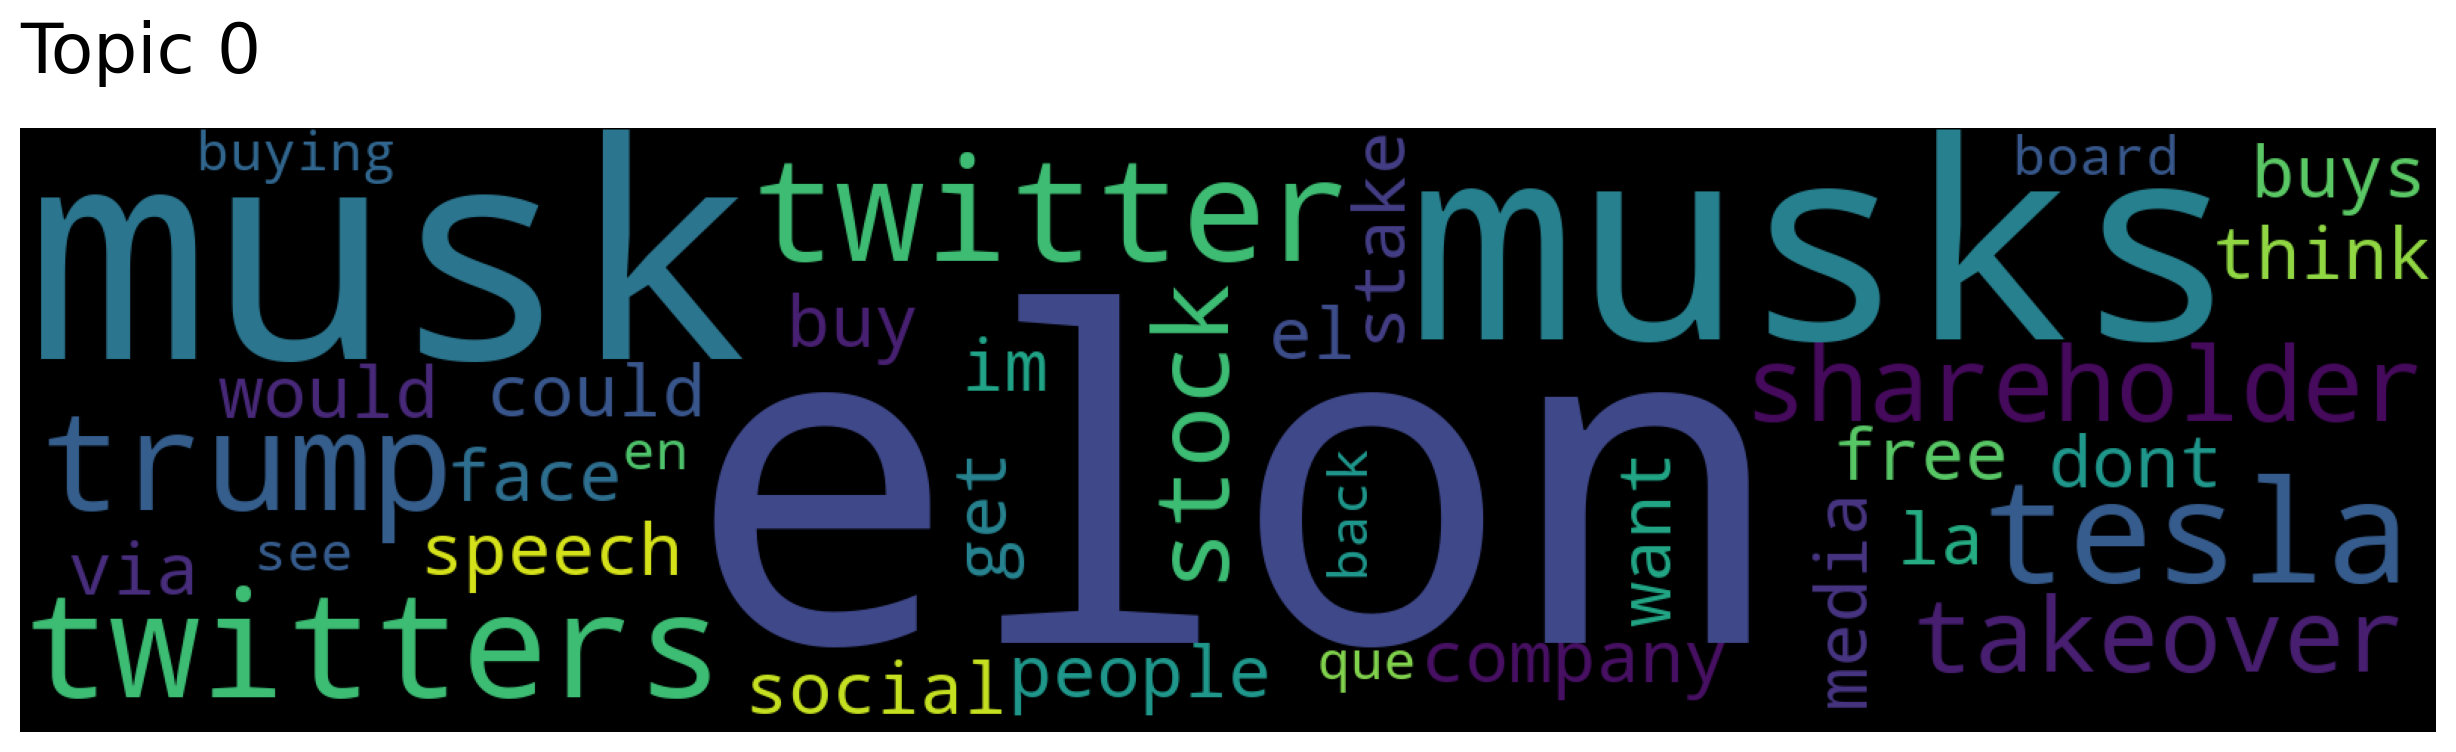

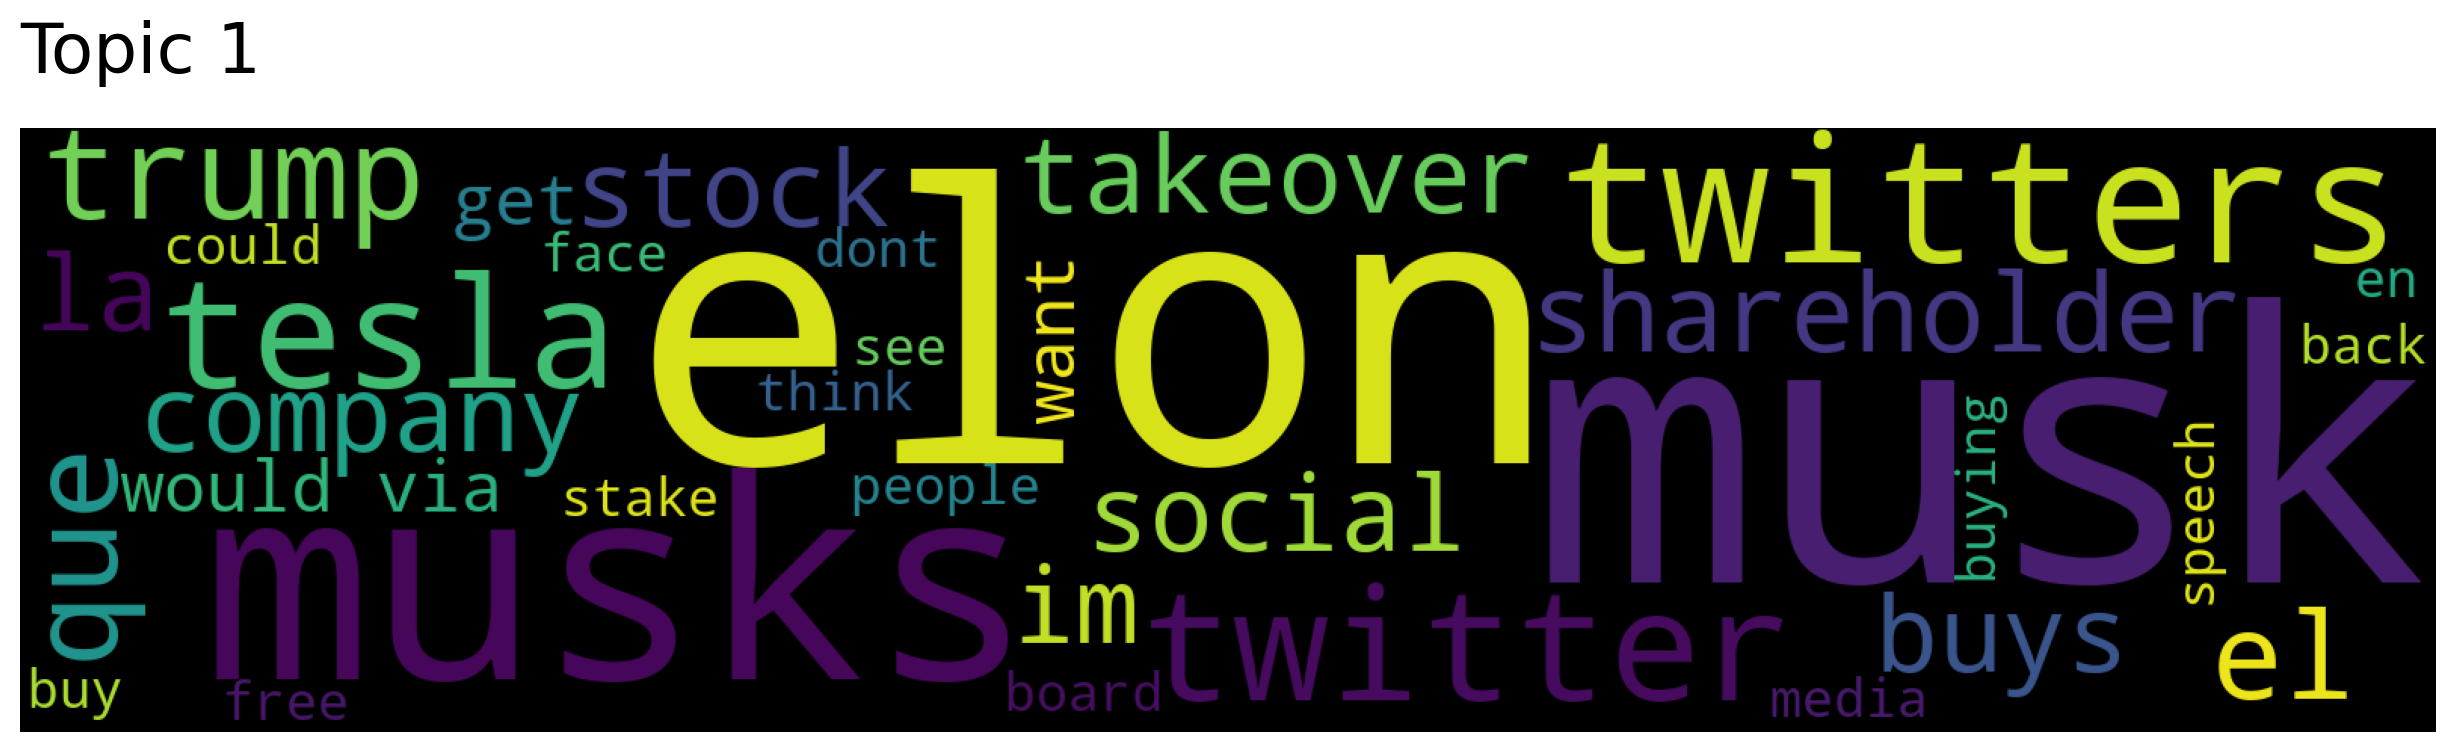

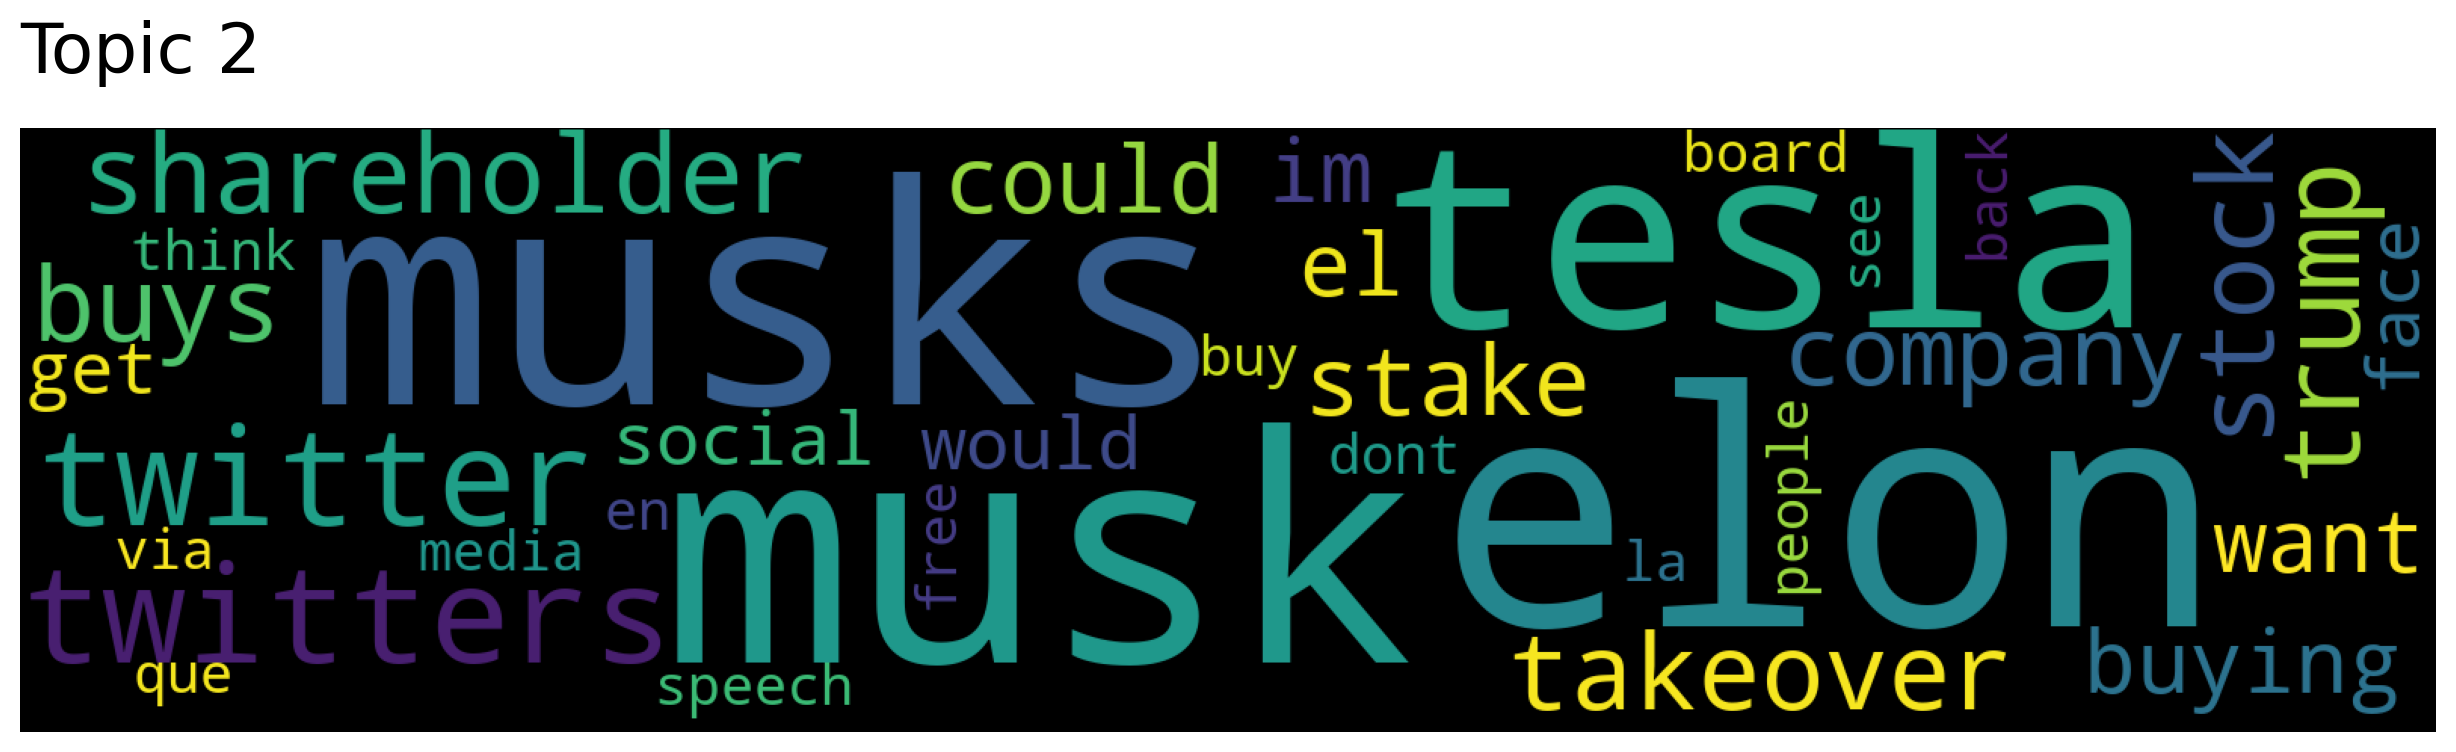

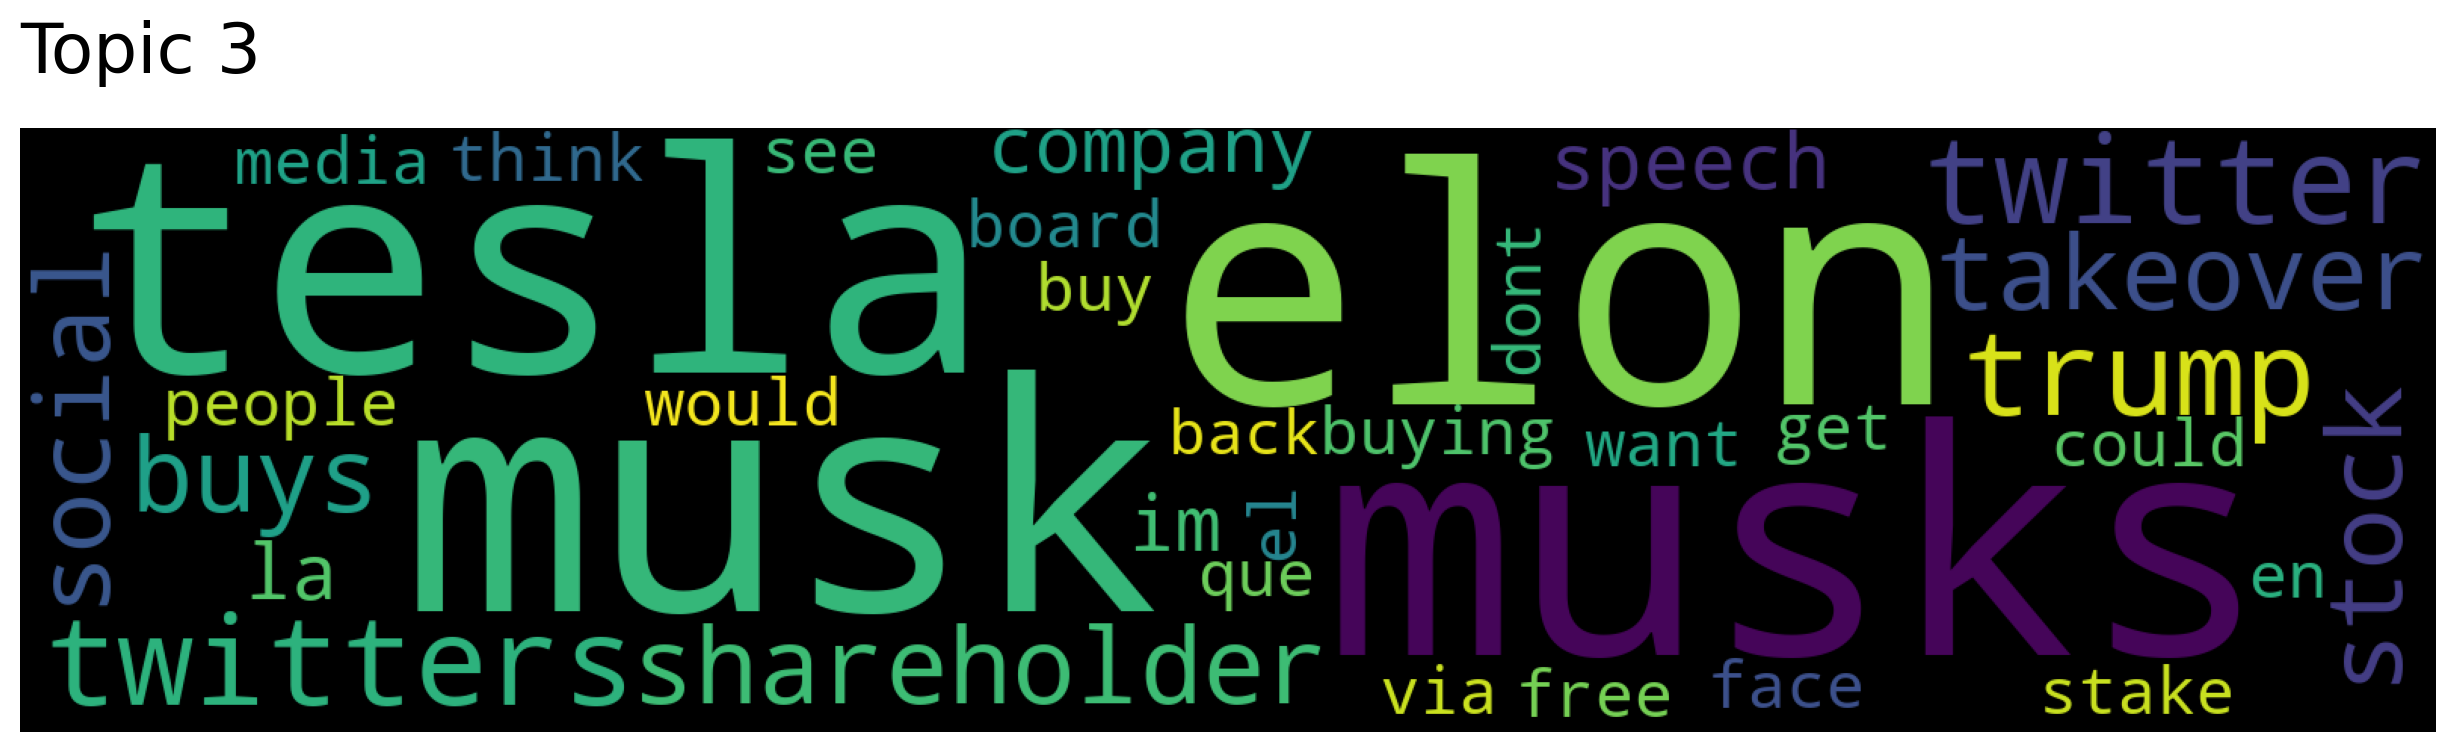

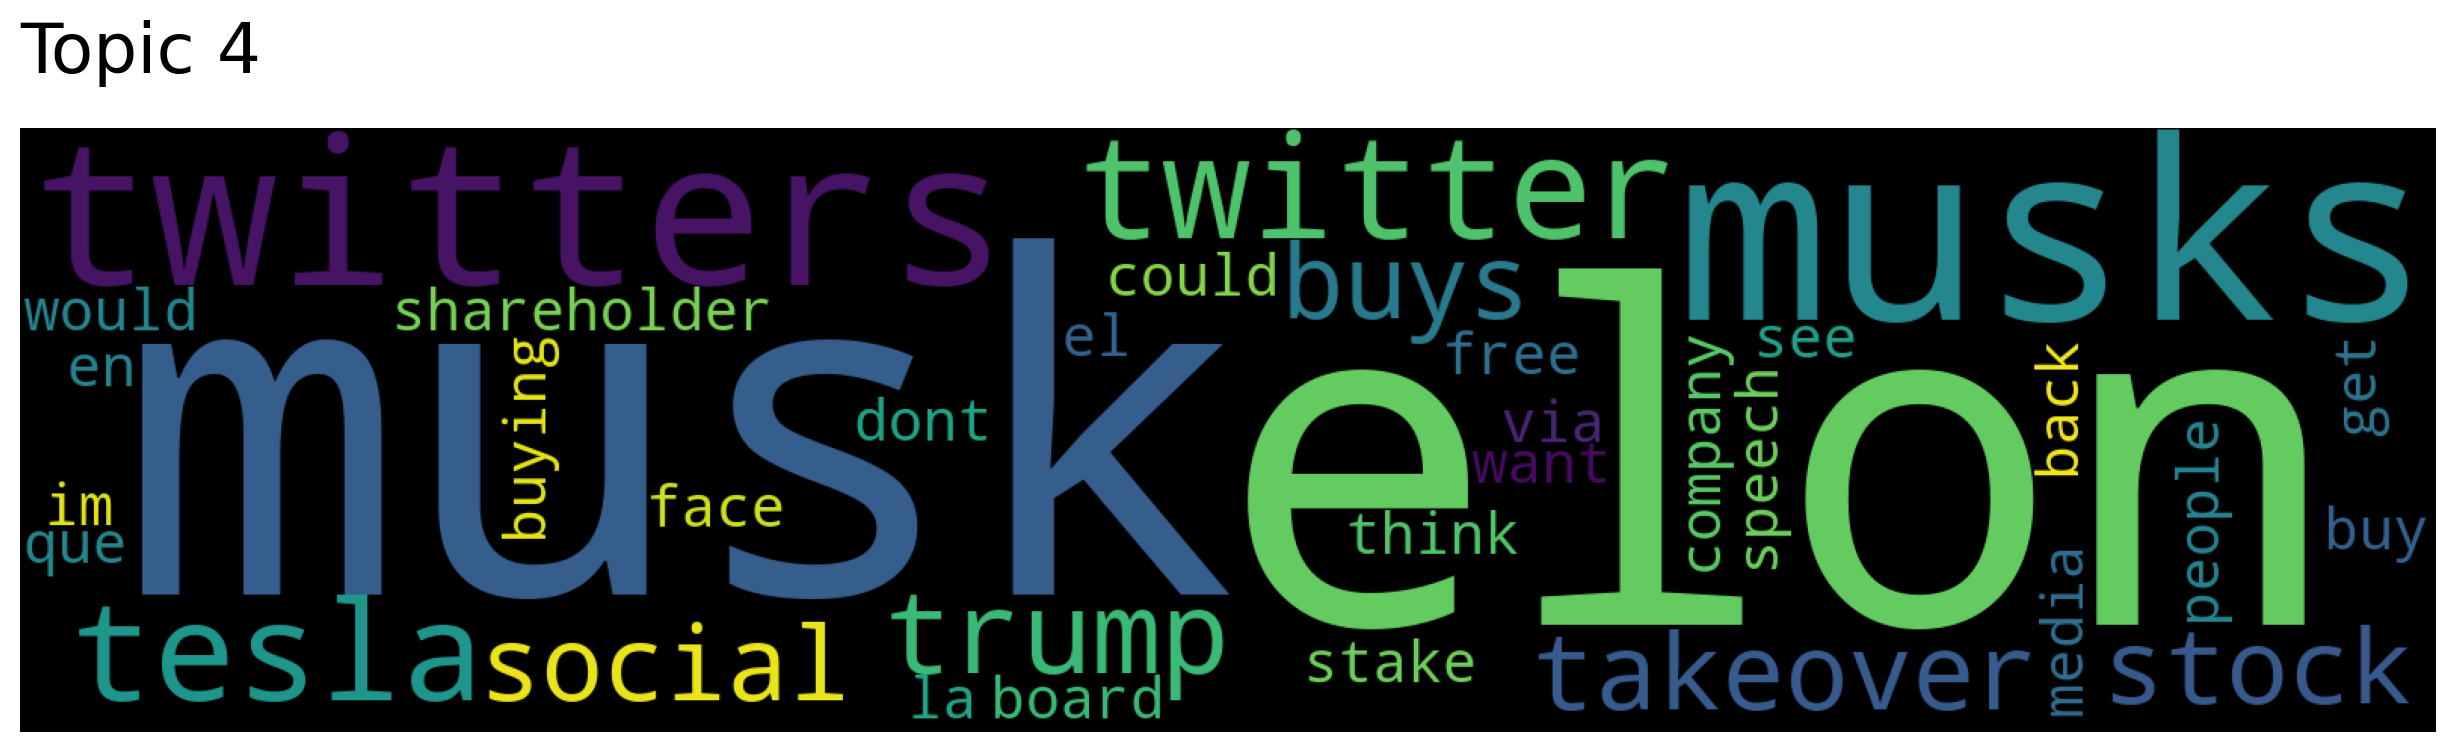

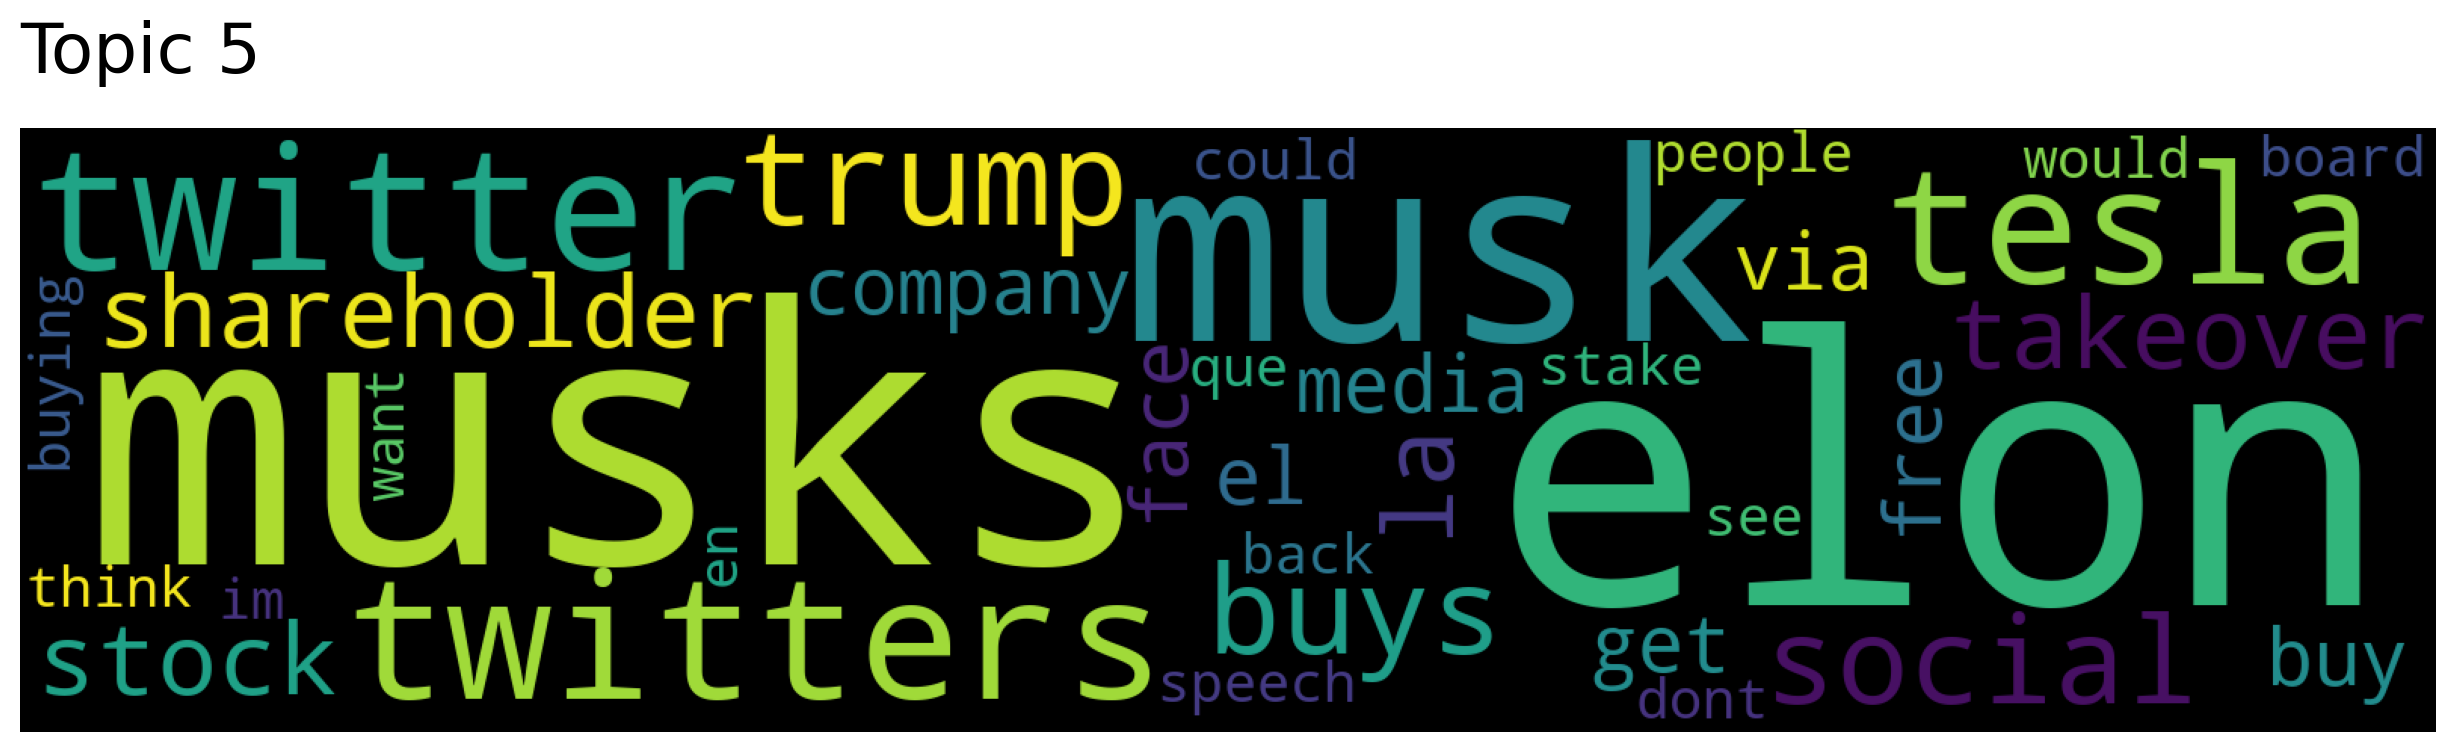

In [130]:
topic_words, word_scores, topic_nums = model.get_topics(6)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [125]:
from nltk.tokenize import word_tokenize
stk_sent = []
for st in stk.cleaned.to_list():
  st = clean_text(st, True, True, True)
  tmp = [w for w in nltk.word_tokenize(st) if w not in stop_words]
  stk_sent.append(' '.join(tmp))

In [67]:
id2word = corpora.Dictionary(stk_sent)
corpus = [id2word.doc2bow(text) for text in stk_sent]
num_topics = 7
# corpus
lda_model_tweets = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

In [68]:
print('Topics:')
for topic in lda_model_tweets.print_topics():
    print(topic)
    print('-'*10)

Topics:
(0, '0.070*"twitter" + 0.061*"elon" + 0.045*"musk" + 0.013*"buy" + 0.009*"board" + 0.007*"speech" + 0.006*"free" + 0.005*"people" + 0.005*"via" + 0.004*"musks"')
----------
(1, '0.032*"elon" + 0.025*"twitter" + 0.017*"musk" + 0.005*"would" + 0.005*"musks" + 0.005*"rolling" + 0.005*"free" + 0.005*"see" + 0.004*"laughing" + 0.004*"floor"')
----------
(2, '0.064*"twitter" + 0.054*"elon" + 0.035*"musk" + 0.007*"via" + 0.006*"buys" + 0.006*"get" + 0.005*"face" + 0.005*"board" + 0.005*"want" + 0.004*"back"')
----------
(3, '0.040*"elon" + 0.038*"twitter" + 0.013*"musk" + 0.006*"board" + 0.006*"say" + 0.005*"media" + 0.005*"buy" + 0.004*"musks" + 0.004*"stock" + 0.004*"speech"')
----------
(4, '0.070*"elon" + 0.066*"twitter" + 0.043*"musk" + 0.008*"board" + 0.006*"trump" + 0.006*"people" + 0.005*"free" + 0.005*"buy" + 0.005*"speech" + 0.005*"think"')
----------
(5, '0.063*"elon" + 0.052*"twitter" + 0.044*"musk" + 0.007*"stock" + 0.006*"shareholder" + 0.005*"stake" + 0.005*"musks" + 0.

In [73]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model_tweets, corpus, id2word)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.054129  0.048982       1        1  25.428518
5     -0.034982 -0.017455       2        1  21.978952
0     -0.063040  0.020294       3        1  18.705772
2     -0.024271 -0.088393       4        1  14.296336
3      0.025087  0.037512       5        1   7.493439
6      0.089682  0.010404       6        1   6.568912
1      0.061652 -0.011344       7        1   5.528071, topic_info=        Term         Freq        Total Category  logprob  loglift
8    twitter  1217.000000  1217.000000  Default  30.0000  30.0000
5       elon  1249.000000  1249.000000  Default  29.0000  29.0000
258       la    51.000000    51.000000  Default  28.0000  28.0000
229      buy   114.000000   114.000000  Default  27.0000  27.0000
468      say    30.000000    30.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
215    money     2.458608    31.801790   Topic7  -6.1874   0.3354
36    speech     2.920020    82.454803   Topic7  -6.0154  -0.4453
210     dont     2.539206    48.424287   Topic7  -6.1551  -0.0528
638     news     2.386477    33.431181   Topic7  -6.2171   0.2557
455     much     2.307732    27.986567   Topic7  -6.2507   0.3999

[555 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3221      1  0.906825      aacak
3703      5  0.470167    abbotts
976       1  0.109519       able
976       2  0.109519       able
976       3  0.438075       able
...     ...       ...        ...
916       6  0.091149        yes
916       7  0.091149        yes
3039      3  0.820069  yesterday
1862      2  0.612974        yet
1862      3  0.245190        yet

[1156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 1, 3, 4, 7, 2])

In [81]:
# sentiment_stock = []
# # i = 0
# for rep in stk_sent:
  
#   sentiment_stock.append(analyzer.predict(' '.join(rep)).output)

### Tweets after musk bought Twitter

In [85]:
base = "buys_elon_twitter_400_"
dfb = []
for i in range(1, 4):
  dfb.append(pd.read_csv(base+str(i)+'.csv')[['date', 'content']])

buys = pd.concat(dfb, ignore_index=True)
del dfb

In [86]:
buys.shape

(1200, 2)

In [87]:
buys['cleaned'] = buys.content.map(lambda x: preprocess_tweet(x, lang="en", shorten=2))

In [88]:
sentiment_buys = []
# i = 0
for rep in buys.cleaned.to_list():
  sentiment_buys.append(analyzer.predict(rep).output)

In [89]:
buys.to_csv('elon_buys_combined.csv')

In [100]:
pd.DataFrame(sentiment_buys).value_counts(normalize=True)

NEU    0.458571
NEG    0.351429
POS    0.190000
dtype: float64

In [101]:
buys_sent = []
for st in stk.cleaned.to_list():
  st = clean_text(st, True, True, True)
  tmp = [w for w in nltk.word_tokenize(st) if w not in stop_words]
  buys_sent.append(' '.join(tmp))

In [ ]:

model_b = Top2Vec(buys_sent, embedding_model='universal-sentence-encoder')

In [106]:
model_b.get_num_topics()

6

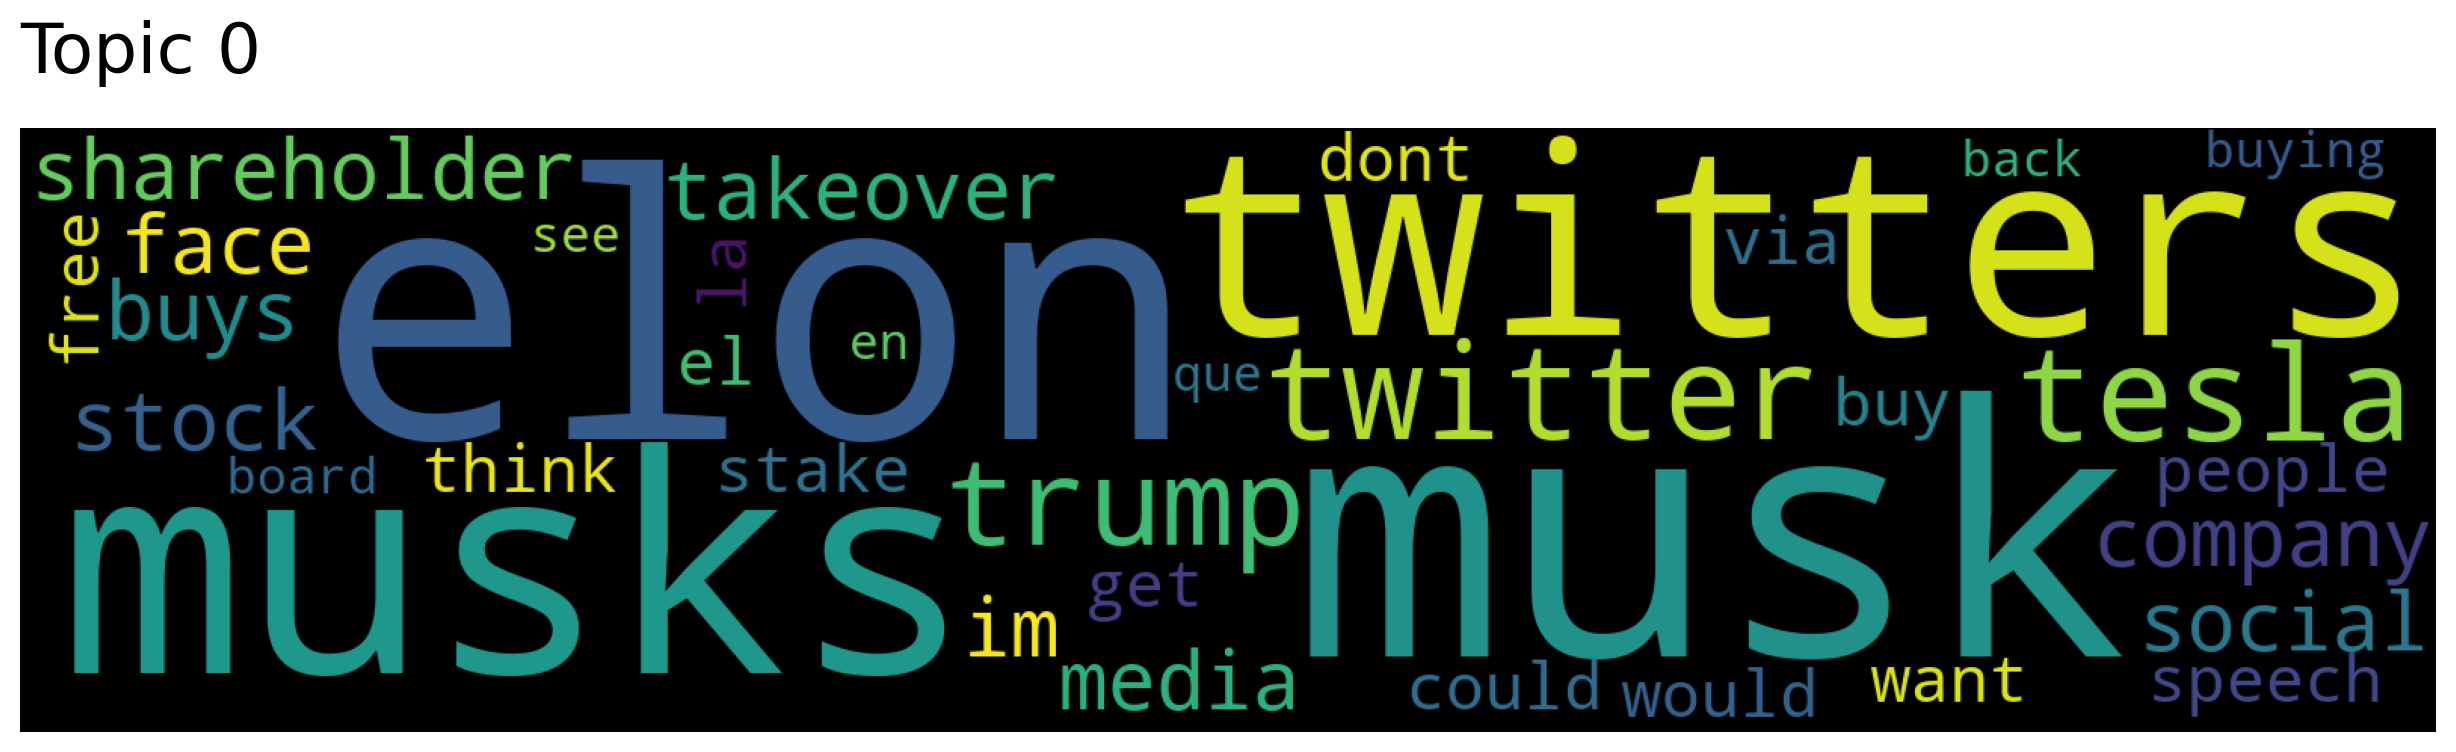

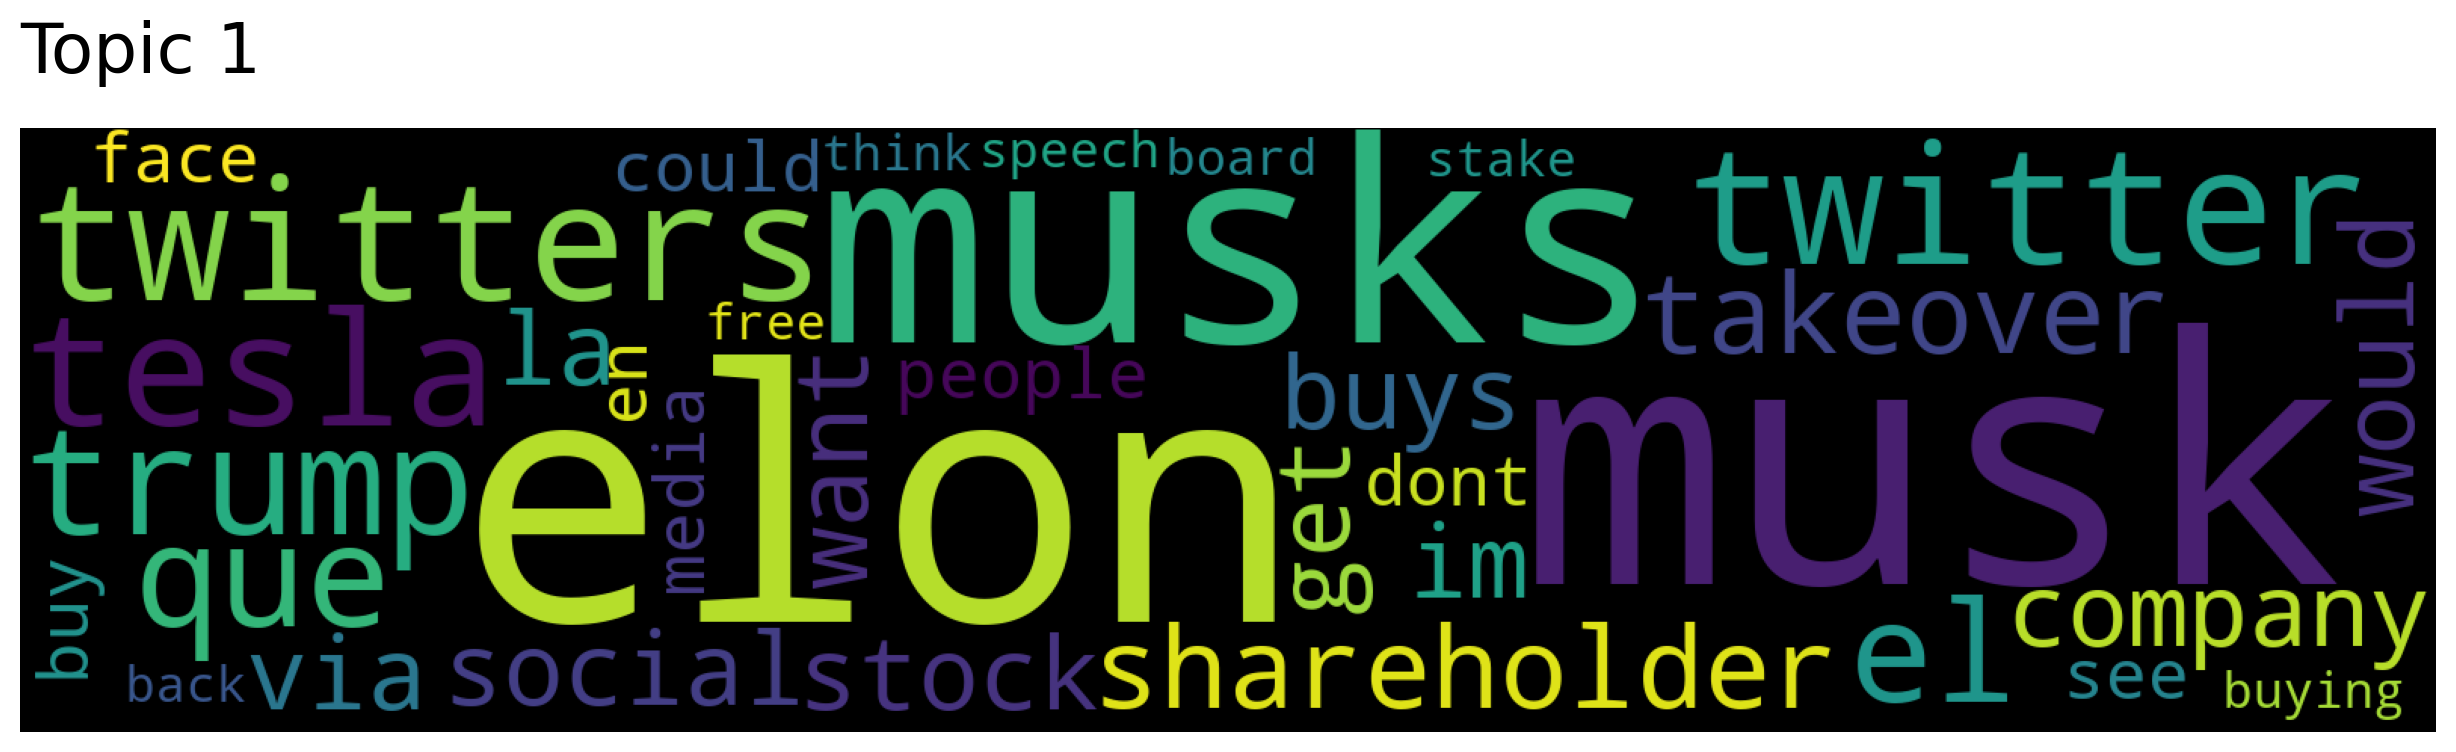

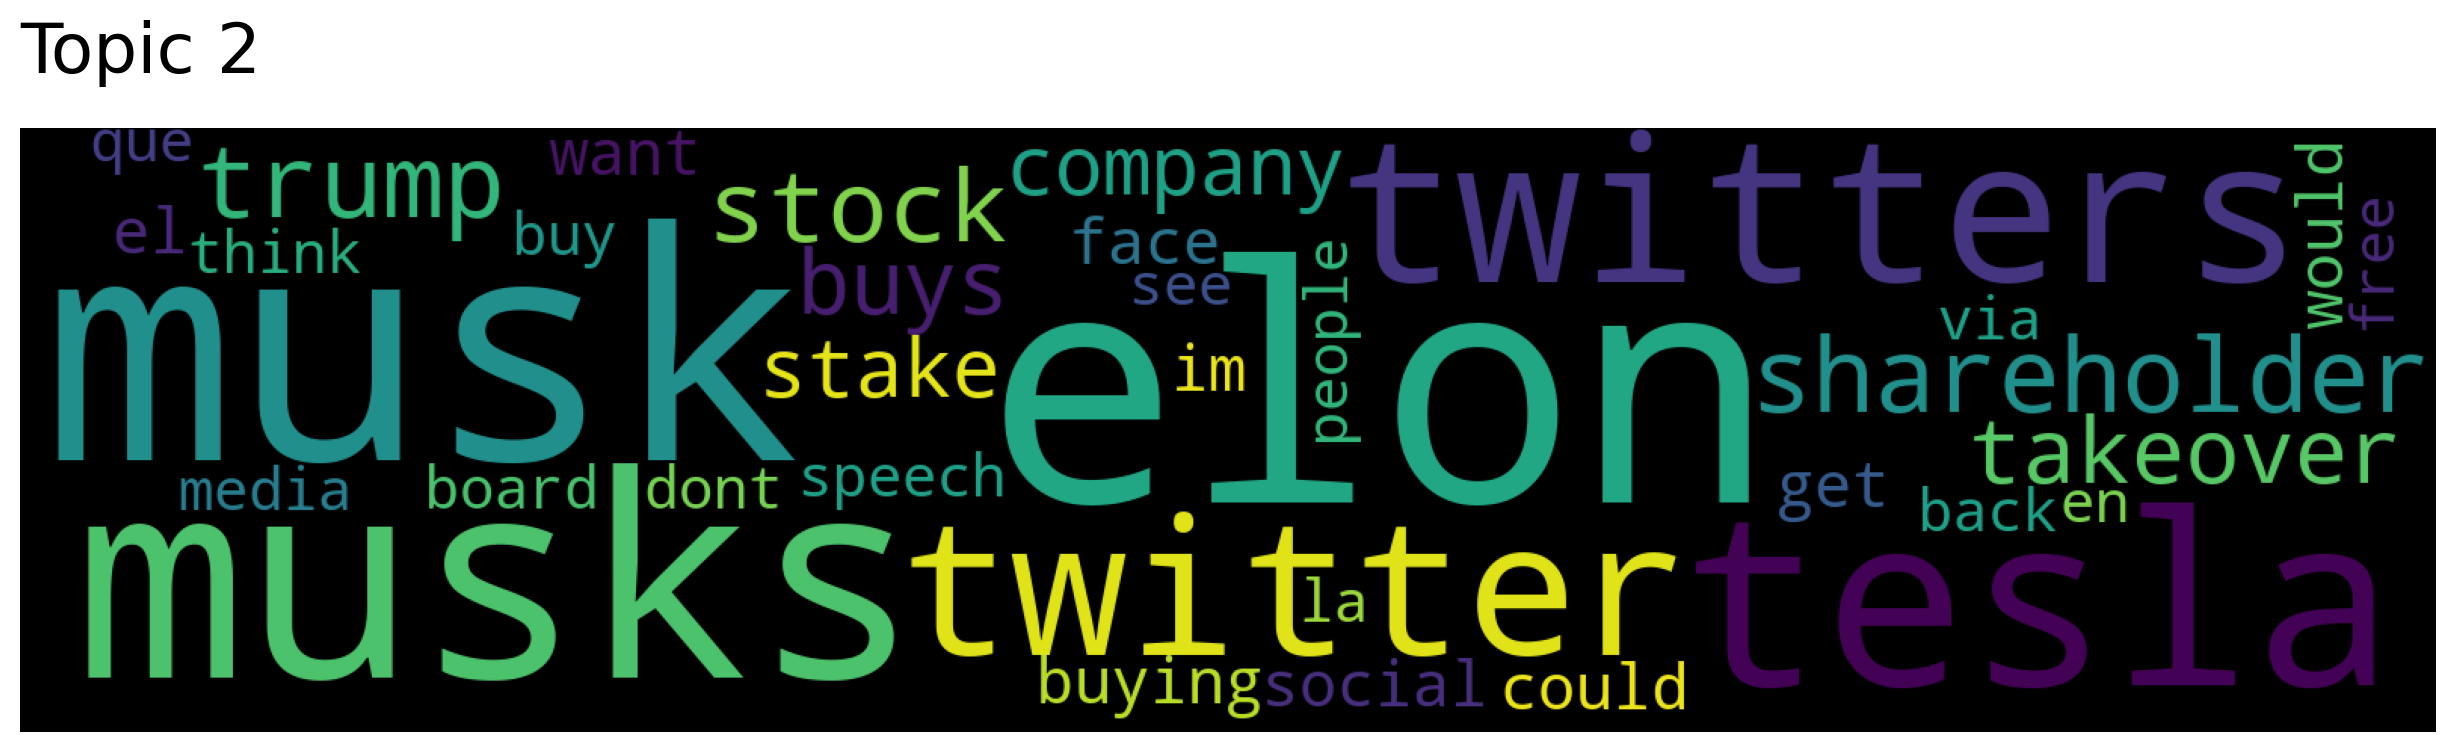

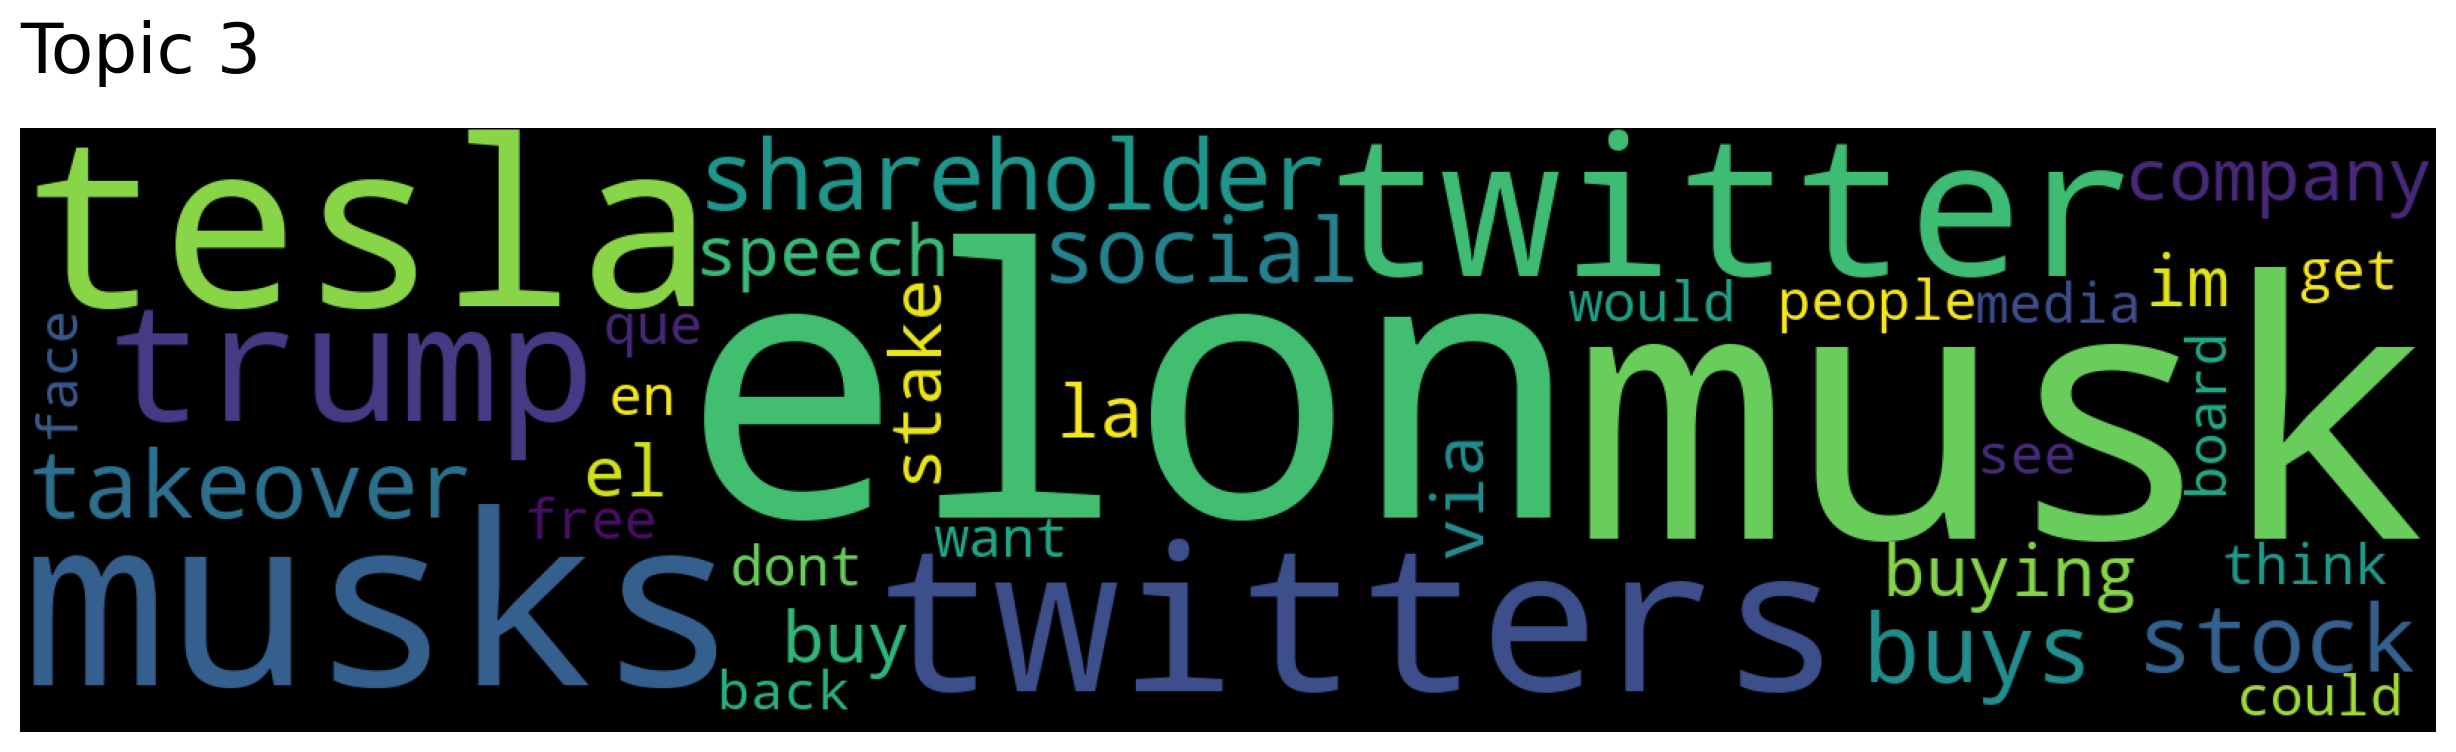

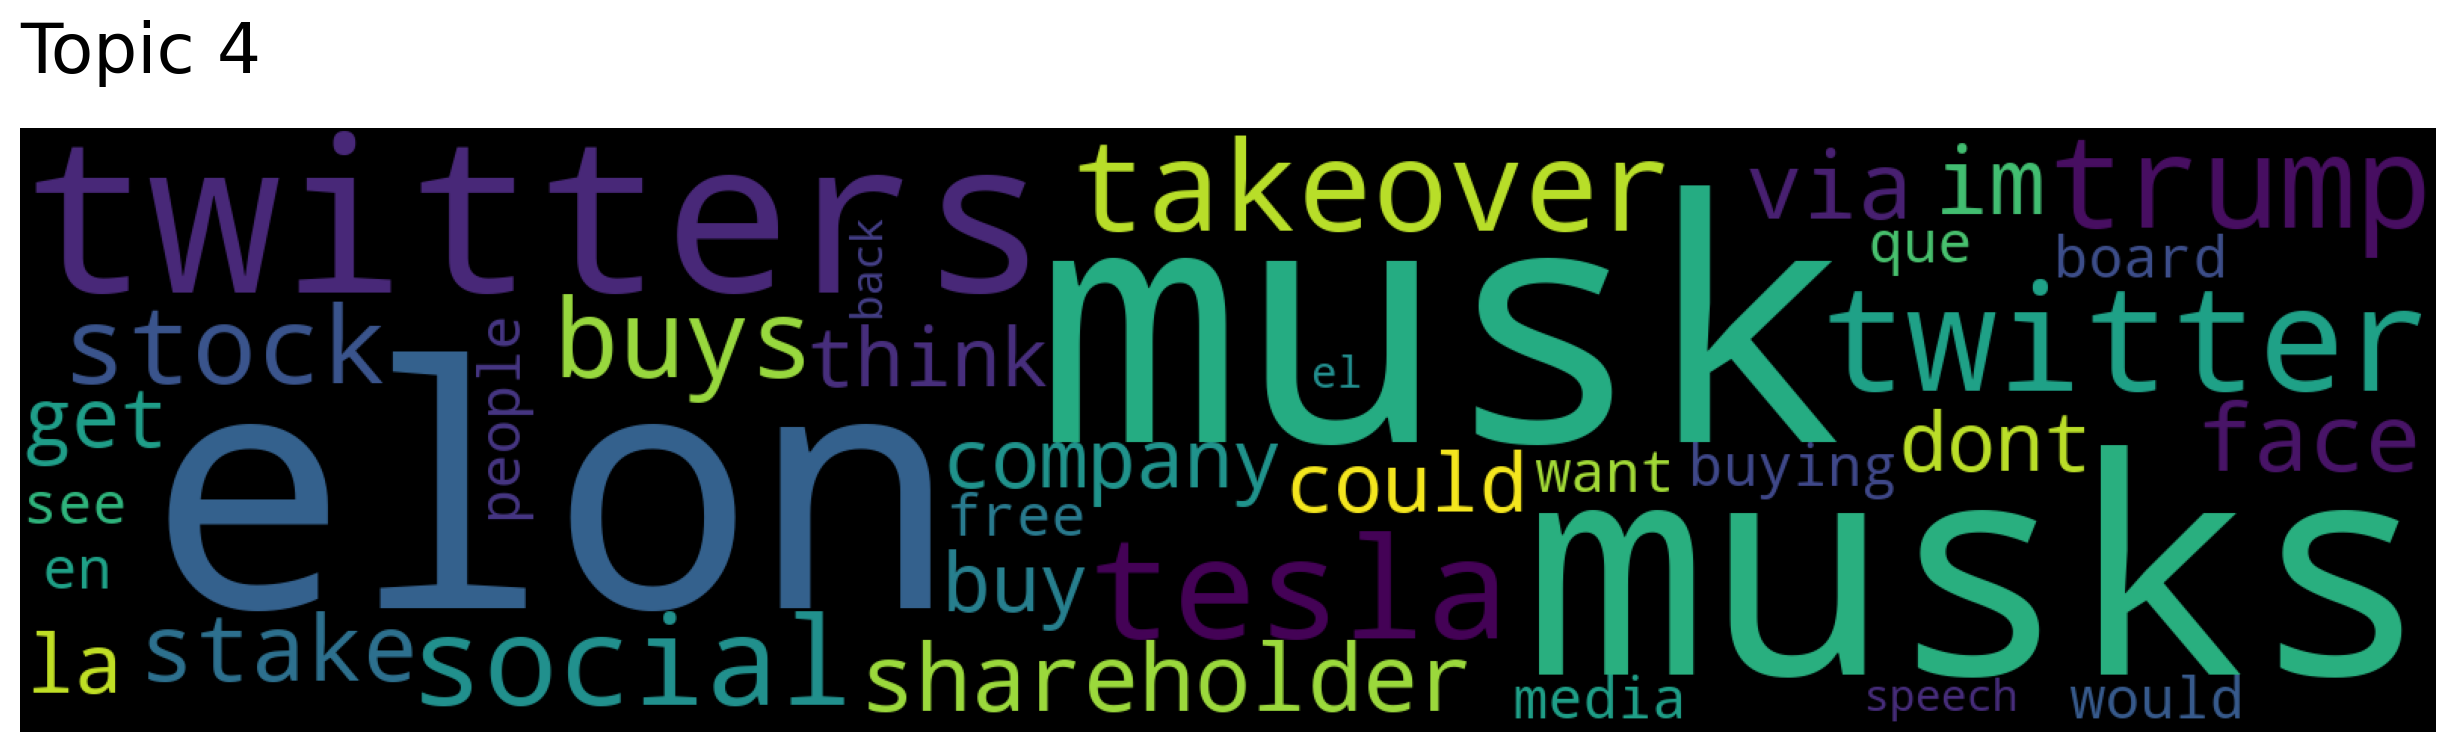

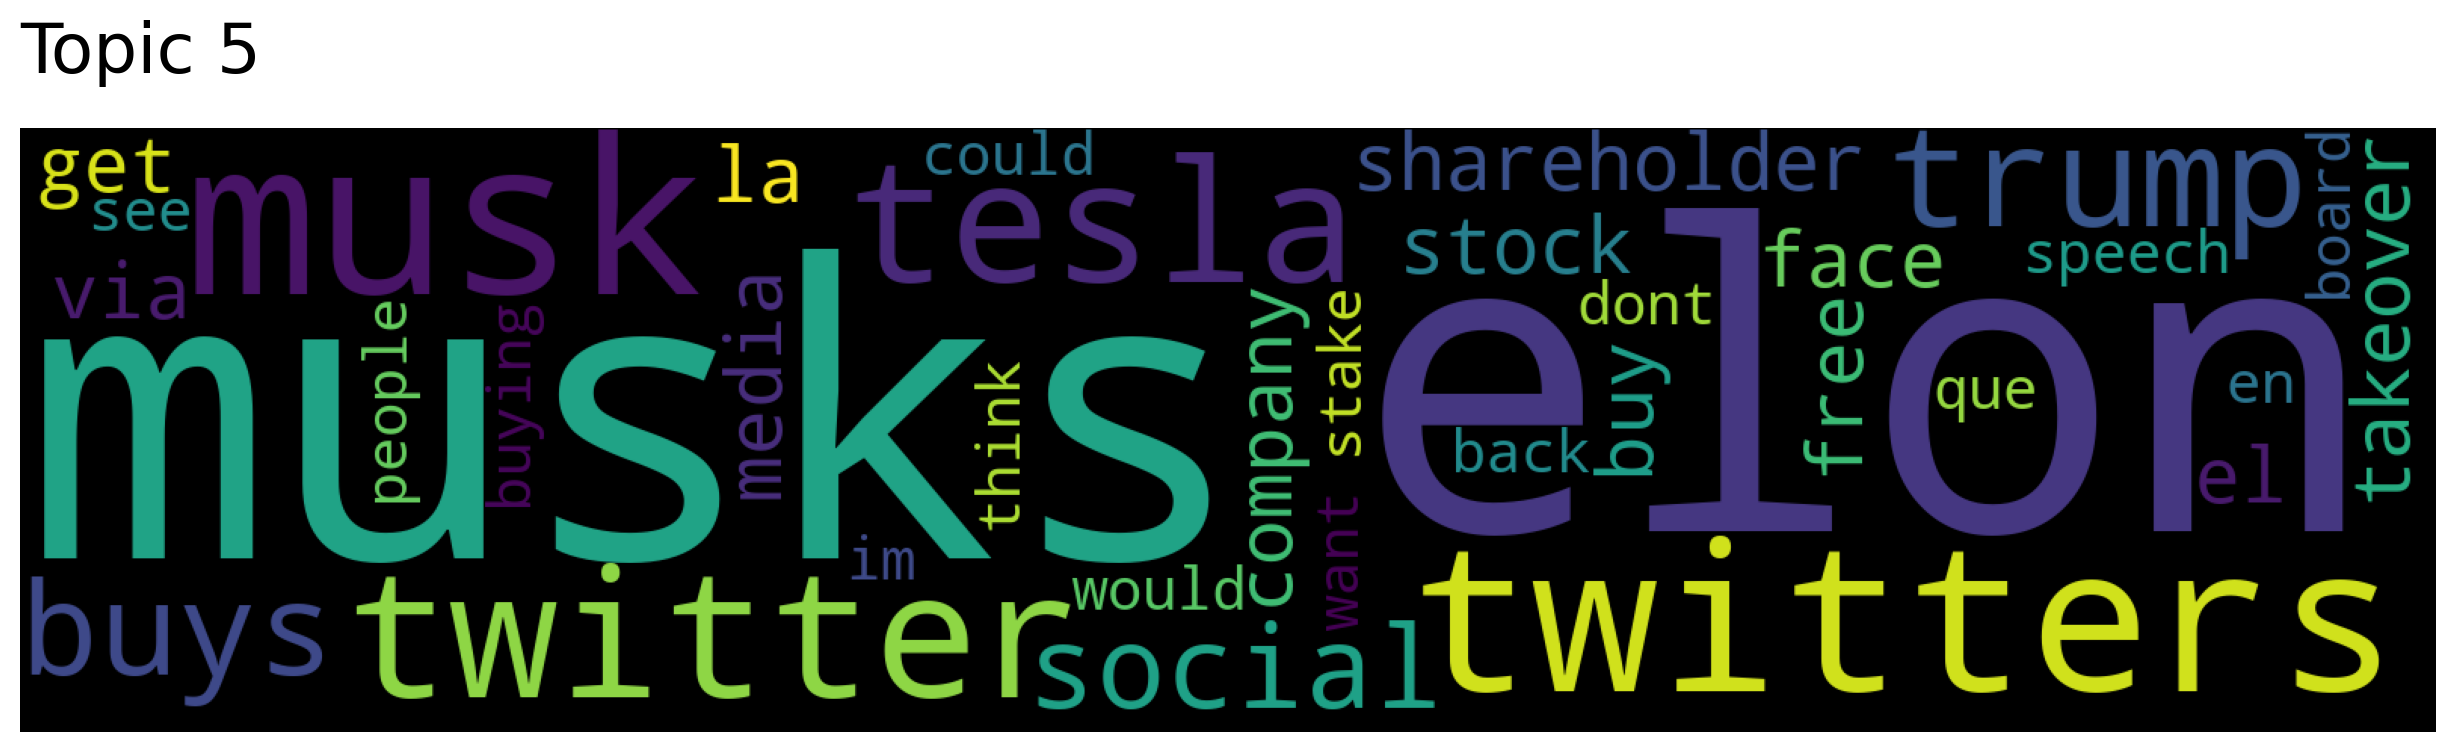

In [107]:
topic_wordsb, word_scoresb, topic_numsb = model_b.get_topics(model_b.get_num_topics())
for topic in topic_numsb:
    model_b.generate_topic_wordcloud(topic)

In [1]:
# from nltk.tokenize import word_tokenize
# stk_sent = []
# for st in stk.cleaned.to_list():
#   st = clean_text(st, True, True, True)
#   tmp = [w for w in nltk.word_tokenize(st) if w not in stop_words]
#   stk_sent.append(tmp)

# buys_sent = [nltk.word_tokenize(b) for b in buys_sent]

In [123]:
id2wordb = corpora.Dictionary(buys_sent)
corpusb = [id2word.doc2bow(text) for text in buys_sent]
num_topics = 6
# corpus
lda_model_b = gensim.models.LdaMulticore(corpus=corpusb,
                                       id2word=id2wordb,
                                       passes = 10,
                                       num_topics=num_topics, iterations=100000)

In [124]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model_tweets, corpus, id2word)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.067458  0.009919       1        1  33.090178
1     -0.073120 -0.019690       2        1  31.443133
5      0.005559 -0.052709       3        1  14.082965
4      0.023406  0.054469       4        1   7.296527
0      0.035190  0.057350       5        1   7.176769
3      0.076424 -0.049339       6        1   6.910428, topic_info=         Term         Freq        Total Category  logprob  loglift
5        elon  1264.000000  1264.000000  Default  30.0000  30.0000
8     twitter  1229.000000  1229.000000  Default  29.0000  29.0000
57        que    55.000000    55.000000  Default  28.0000  28.0000
120      back    53.000000    53.000000  Default  27.0000  27.0000
11         en    43.000000    43.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
380     musks     3.575951    79.864953   Topic6  -6.0359  -0.4340
50   twitters     3.340363    61.896723   Topic6  -6.1041  -0.2472
455      much     2.829865    28.720632   Topic6  -6.2699   0.3548
206     tesla     3.041929    45.776323   Topic6  -6.1977  -0.0391
120      back     3.009732    53.658640   Topic6  -6.2083  -0.2087

[466 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3703      5  0.477886   abbotts
393       3  0.791682  acciones
1021      1  0.136739  accounts
1021      2  0.410217  accounts
1021      3  0.136739  accounts
...     ...       ...       ...
457       2  0.228795     would
457       3  0.076265     would
457       4  0.091518     would
457       5  0.076265     would
457       6  0.030506     would

[910 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 6, 5, 1, 4])